# **Методы аппроксимации в интерполяции и прогнозировании цен NVIDIA**

## **Введение**
В этой тетради мы рассмотрим несколько методов интерполяции и аппроксимации, применяемых к набору данных, представляющему общие данные корпорации NVIDIA. Цель состоит в том, чтобы повысить точность прогнозов с помощью различных математических моделей.

### **Цели:**
- Применить различные методы аппроксимации к заданному набору данных.
- Проанализировать результаты этих моделей.
- Сравнить эффективность каждого метода.
- Использовать библиотеки Python, такие как "numpy", "scipy", "matplotlib" и "pandas", для реализации моделей.
  
Методы, которые мы будем изучать, включают:
- **Интерполяцию полиномом Лагранжа**
- **Интерполяция полиномом Ньютона**
- **Интерполяция кубическим сплайном**
- **Аппроксимация методом наименьших квадратов**
- **Аппроксимация наименьшими модулями**
- **Сигмовидные методы аппроксимации**
- **Корни полинома Чебышева для улучшения интерполяции**

---

Установим пропущенные библиотеки

In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install scipy

## **1. Загружаем датасет**

Мы начнем с загрузки и проверки набора данных. Набор данных содержит значения данные о стоимости акций NVIDIA (1/22/1999 - 11/16/2022) и может быть использован для дальнейшего анализа инвестиций.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('NVIDIA Corporation.csv', index_col='Date', parse_dates=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-01-22,0.488281,0.388021,0.437500,0.410156,271468800,0.376518
1999-01-25,0.458333,0.410156,0.442708,0.453125,51048000,0.415963
1999-01-26,0.467448,0.411458,0.458333,0.417969,34320000,0.383690
1999-01-27,0.429688,0.395833,0.419271,0.416667,24436800,0.382495
1999-01-28,0.419271,0.412760,0.416667,0.415365,22752000,0.381300


In [3]:
df.columns  # if you want to have Date as a column instead of index, then remove argument "index_col='Date' from read_csv function"

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

---

## **2. Визуализируем данные**

Давайте построим график данных, чтобы получить представление о их поведении.

<Axes: xlabel='Date'>

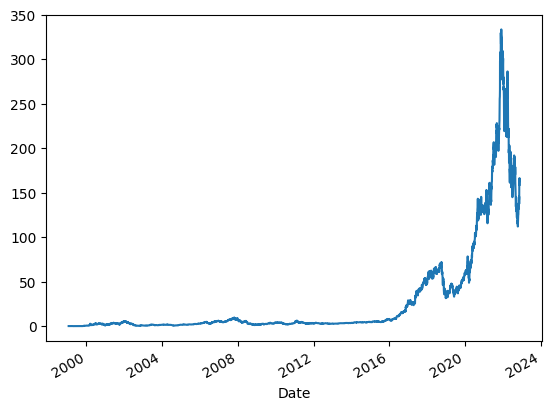

In [4]:
# Simplest way to plot data frame
df['Close'].plot()

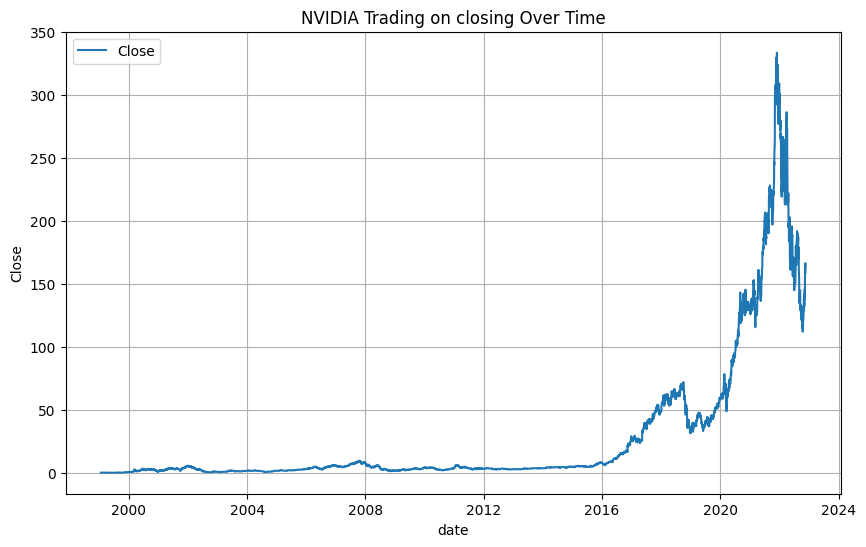

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close')
# plt.scatter(df['date'], df['Close'], color='red', label='Data Points')
plt.xlabel('date')
plt.ylabel('Close')
plt.title('NVIDIA Trading on closing Over Time')
plt.legend()
plt.grid(True)
plt.show()

---

## **3. Интерполяция полиномом Лагранжа**

### Обзор метода:
Интерполяция Лагранжа - это метод построения многочлена, который проходит через заданный набор точек данных.

### Реализация:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
import pandas as pd

Мы ограничиваем количество точек для интерполяции, потому что в противном случае у нас будет полином в степени 5000+, построение и последующее использование которого займет огромное количество времени. Мы предполагаем, что наибольшие и наименьшие точки будут влиять на интерполяцию больше, чем другие, но на самом деле это означает, что мы строим интерполяцию на основе выбросов, что на практике обычно неверно.

In [86]:
# Select the 5 highest and 5 lowest points based on 'Close' values
df_top5_high = df.nlargest(5, 'Close')
df_top5_low = df.nsmallest(5, 'Close')
df_top10 = pd.concat([df_top5_high, df_top5_low]).sort_index()
df_top10 = df.sample(10)
# print(df_top10)
print(len(df_top10))

10


In [87]:
# Convert index to numerical values for interpolation
dates_numeric = df_top10.index.astype(np.int64) // 10**9  # Convert to seconds since epoch

# Create the Lagrange interpolating polynomial using the top 10 points
poly_lagrange = lagrange(dates_numeric, df_top10['Close'])
print(poly_lagrange)

           9             8             7             6             5
1.132e-71 x - 1.442e-61 x + 8.139e-52 x - 2.668e-42 x + 5.598e-33 x
              4           3             2
 - 7.795e-24 x + 7.2e-15 x - 4.252e-06 x + 1457 x - 2.205e+11


/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:82: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pt = poly1d(w[j])


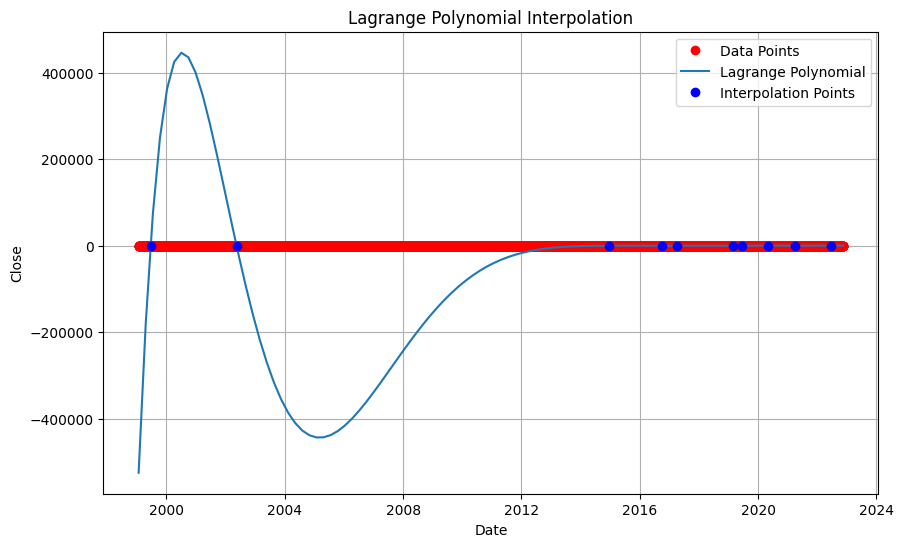

In [88]:
# Define a range of dates for plotting the interpolation
date_range = np.linspace(df.index[0].value // 10**9, df.index[-1].value // 10**9, 100)

# Calculate values by interpolation polynomial
closing_lagrange = poly_lagrange(date_range)
# Convert date_range back to datetime for plotting
date_range = pd.to_datetime(date_range * 10**9)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_lagrange, label='Lagrange Polynomial')
plt.plot(df_top10.index, df_top10['Close'], 'bo', label='Interpolation Points')  # Add interpolation points
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Lagrange Polynomial Interpolation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Проанализируйте поведение интерполяции полиномом Лагранжа и ее пригодность для вашего набора данных.
- Попробуйте увеличить или уменьшить количество точек данных, чтобы увидеть, как это повлияет на интерполяцию.

### Ответ
- Лагранжева интерполяция с большим количеством точек может оказаться неустойчивой и приводить к неинтуитивным результатам (резкие пики, уход к очень большим значениям и т.п.).
- Если данные (особенно финансовые временные ряды) имеют шум, разрывы, тренды или сезонность, один глобальный полином высокой степени обычно не подходит для точного моделирования или прогноза.
- Для практического использования обычно предпочитают сплайны, метод наименьших квадратов или другие более «устойчивые» методы аппроксимации.

---

## **4. Интерполяция полиномом Ньютона**

### Обзор метода:
Метод Ньютона позволяет итеративно строить интерполяционный полином и в некоторых случаях может быть более стабильным, чем метод Лагранжа.

### Реализация:

In [11]:
from scipy.interpolate import BarycentricInterpolator

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
import pandas as pd

Мы ограничиваем количество точек для интерполяции, потому что в противном случае у нас будет полином в степени 5000+, построение и последующее использование которого займет огромное количество времени. Мы предполагаем, что наибольшие и наименьшие точки будут влиять на интерполяцию больше, чем другие, но на самом деле это означает, что мы строим интерполяцию на основе выбросов, что на практике обычно неверно.

In [64]:
# Select the 5 highest and 5 lowest points based on 'Close' values
df_top5_high = df.nlargest(50, 'Close')
df_top5_low = df.nsmallest(50, 'Close')
df_top10 = pd.concat([df_top5_high, df_top5_low]).sort_index()
df_top10 = df.sample(3)
# print(df_top10)
print(len(df_top10))

3


In [65]:
# Convert index to numerical values for interpolation
dates_numeric = df_top10.index.astype(np.int64) // 10**9  # Convert to seconds since epoch

# Create the Newton interpolator (using Barycentric for simplicity)
newton_interpolator = BarycentricInterpolator(dates_numeric, df_top10['Close'])

# Calculate interpolated values
closing_newton = newton_interpolator(date_range)

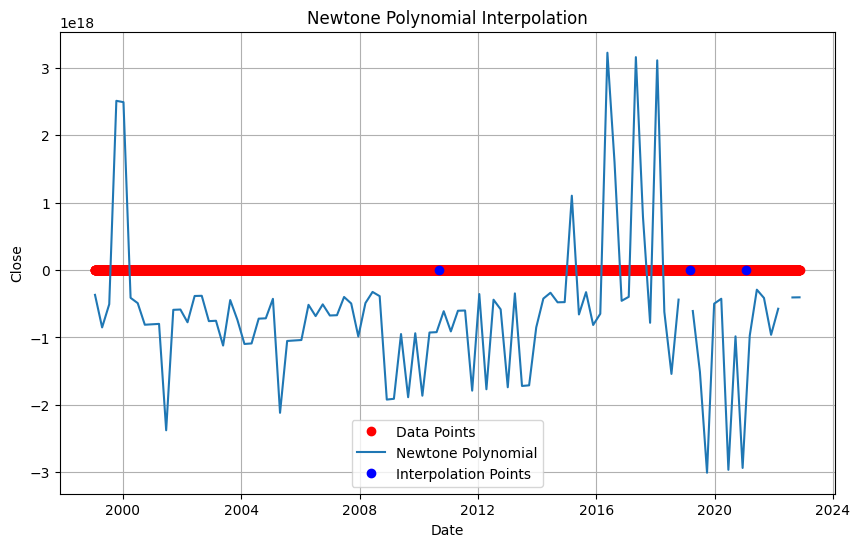

In [66]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_newton, label='Newtone Polynomial')
plt.plot(df_top10.index, df_top10['Close'], 'bo', label='Interpolation Points')  # Add interpolation points
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Newtone Polynomial Interpolation')
plt.legend()
plt.grid(True)
plt.show()

### Задание:
- Сравните результаты применения полинома Ньютона с полиномом Лагранжа. В чем основные различия?
- Что происходит, когда вы меняете порядок интерполяции?

### Ответ
- При одинаковом наборе точек полиномы Ньютона и Лагранжа дают один и тот же результат, но по-разному формулируются и могут различаться в численной устойчивости (Ньютон часто более стабилен).
- При увеличении порядка (числа точек) возрастает риск «эффекта Рунге» — резких колебаний между точками; при уменьшении порядка полином становится более «гладким», но менее точным в промежутках.

---

## **5. Интерполяция кубическими сплайнами**

### Обзор метода:
Интерполяция кубическими сплайнами сопоставляет данные с кусочно-кубической функцией, обеспечивая плавные переходы между точками. Этот метод часто обеспечивает более плавную аппроксимацию, чем полиномиальные методы.

### Реализация:

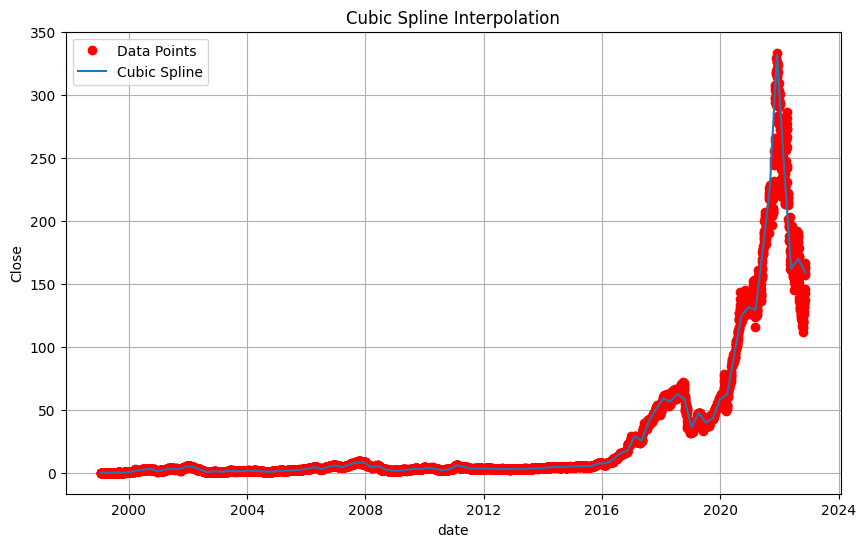

In [15]:
from scipy.interpolate import CubicSpline

# Create the Cubic Spline interpolator
cubic_spline = CubicSpline(df.index, df['Close'])

# Calculate interpolated values
closing_spline = cubic_spline(date_range)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_spline, label='Cubic Spline')
plt.xlabel('date')
plt.ylabel('Close')
plt.title('Cubic Spline Interpolation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Сравните кубическую сплайновую интерполяцию с другими методами. Как она позволяет более эффективно обрабатывать данные?
- Как бы вы применили этот метод к точкам данных с выбросами?

### Ответ

#### Сравнение с полиномиальной интерполяцией

- Кубические сплайны строят «кусочно-полиномиальные» функции между соседними точками, обеспечивая гладкость до второй производной. Это предотвращает резкие «пики» и «провалы», характерные для полиномиальной интерполяции высокой степени (эффект Рунге).
- Сплайны хорошо работают на больших наборах данных и более устойчивы в вычислительном плане, так как не требуют единого полинома большой степени.

#### Обработка выбросов
- Если данные содержат аномальные точки (выбросы), можно либо предварительно их отфильтровать/заменить, либо применить сглаженные сплайны (например, UnivariateSpline с параметром сглаживания s).
- Такой подход не будет «заставлять» сплайн проходить точно через выброс, а найдёт компромисс между точным прохождением точек и общей гладкостью кривой.

---

## **6. Аппроксимация методом наименьших квадратов**

### Обзор метода:
Приближение методом наименьших квадратов минимизирует сумму квадратов различий между наблюдаемыми точками данных и моделью.

### Реализация:

/usr/local/lib/python3.11/dist-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


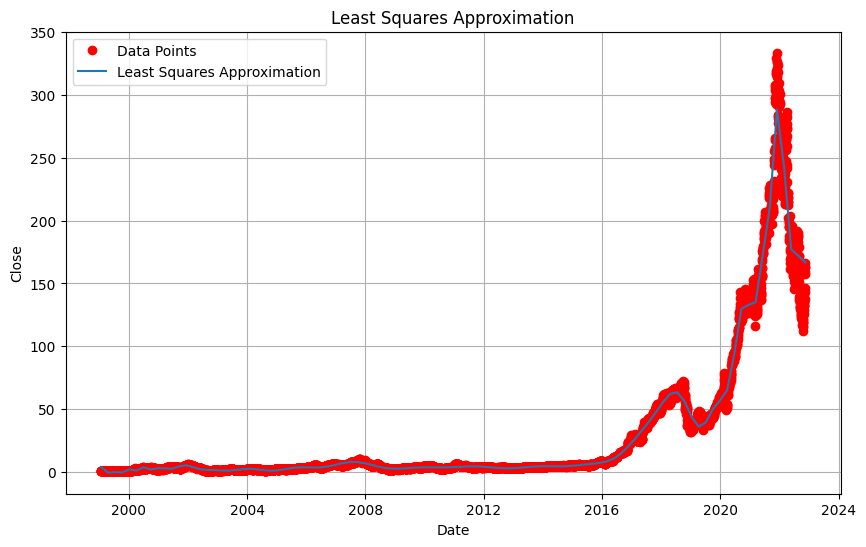

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import pandas as pd

# Convert index to numerical values for fitting the polynomial
dates_numeric = df.index.astype(np.int64) // 10**9  # Convert to seconds since epoch

# Fit a least squares polynomial of degree 2
p = Polynomial.fit(dates_numeric, df['Close'], 200)

# Define a range of dates for plotting the approximation
date_range = np.linspace(dates_numeric[0], dates_numeric[-1], 100)

# Calculate values
closing_least_squares = p(date_range)

# Convert date_range back to datetime for plotting
date_range = pd.to_datetime(date_range * 10**9)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_least_squares, label='Least Squares Approximation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Least Squares Approximation')
plt.legend()
plt.grid(True)
plt.show()

Теперь попробуем выполнить тоже самое, но логарифмической функцией

/usr/local/lib/python3.11/dist-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


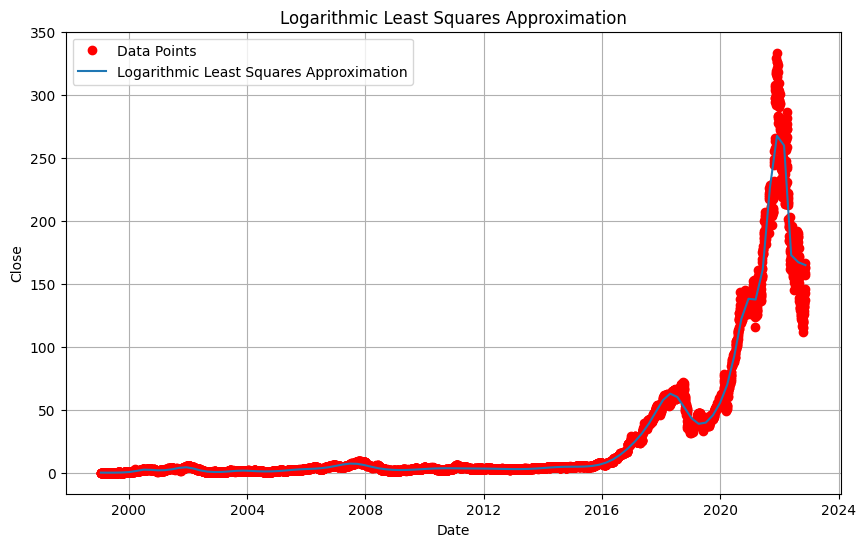

In [53]:
# Logarithmic approximation for least squares method
# Convert index to numerical values for fitting the polynomial
dates_numeric = df.index.astype(np.int64) // 10**9  # Convert to seconds since epoch

# Logarithmic approximation for least squares method
# Transform 'Close' values using the natural logarithm
log_close = np.log(df['Close'])

# Fit a least squares polynomial of degree 2 to the log-transformed data
p_log = Polynomial.fit(dates_numeric, log_close, 100)

# Define a range of dates for plotting the approximation
date_range = np.linspace(dates_numeric[0], dates_numeric[-1], 100)

# Calculate values for the log-transformed polynomial
log_close_least_squares = p_log(date_range)

# Convert back from log scale to original scale
log_close_least_squares = np.exp(log_close_least_squares)

# Convert date_range back to datetime for plotting
date_range = pd.to_datetime(date_range * 10**9)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, log_close_least_squares, label='Logarithmic Least Squares Approximation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Logarithmic Least Squares Approximation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Попробуйте использовать разные степени многочлена. Как улучшается или ухудшается приближение?
- Дополнительно Вы можете попробовать использовать различные функции для аппроксимации (экспоненциальную, тригонометрическую и т.д.).

### Ответ

- При малой степени полинома модель может быть слишком «грубой» и плохо отражать реальные колебания данных.
- При высокой степени возрастает риск переобучения: полином будет подстраиваться под шум и «гулять» за пределами диапазона наблюдений.


- Если данные растут экспоненциально, имеет смысл применять логарифмическую аппроксимацию (логарифмирование целевой переменной), либо прямо использовать экспоненциальные функции.
- Для периодических данных можно использовать тригонометрические или Fourier-составляющие.
- В целом выбор функции зависит от характера данных и предполагаемой модели роста/спада.

---

## **7. Приближение по наименьшим модулям**

### Обзор метода:
Метод наименьших модулей минимизирует сумму абсолютных различий (а не квадратичных различий) между моделью и данными.

### Реализация:

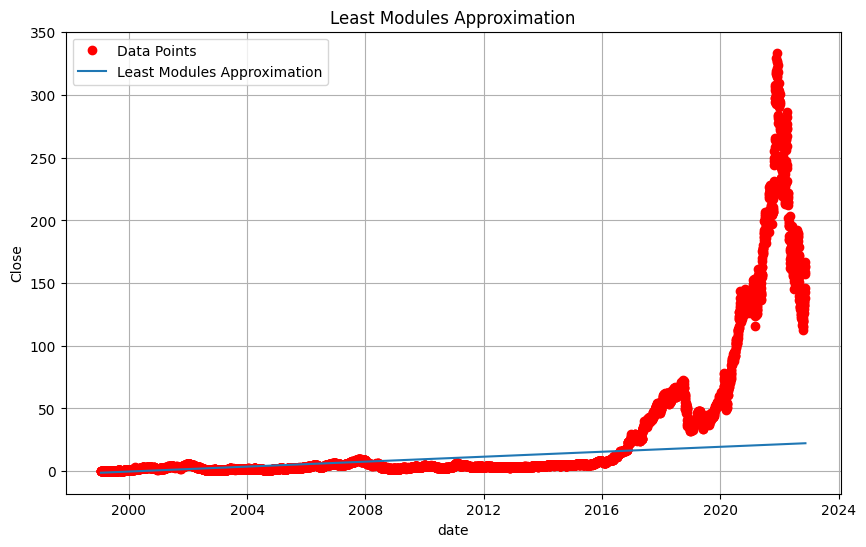

In [18]:
from scipy.optimize import minimize

def least_modules_model(x, years, close):
    # Simple linear model: f(x) = ax + b
    a, b = x
    return sum(abs(a * years + b - close))

# Initial guess for the parameters
initial_guess = [1, 1]

# Convert index to numerical values for fitting the polynomial
dates_numeric = df.index.astype(np.int64) // 10**9  # Convert to seconds since epoch

# Minimize the absolute difference (Least Modules)
result = minimize(least_modules_model, initial_guess, args=(dates_numeric, df['Close']))
a, b = result.x

# Define a range of dates for plotting the approximation
date_range = np.linspace(dates_numeric[0], dates_numeric[-1], 100)

# Calculate values
closing_least_modules = a * date_range + b

# Convert date_range back to datetime for plotting
date_range = pd.to_datetime(date_range * 10**9)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_least_modules, label='Least Modules Approximation')
plt.xlabel('date')
plt.ylabel('Close')
plt.title('Least Modules Approximation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Как ведет себя метод наименьших модулей по сравнению с методом наименьших квадратов?

### Ответ

- Метод наименьших квадратов (L2-норма) сильнее «наказывает» большие отклонения, поэтому отдельные выбросы могут сильно влиять на результат.
- Метод наименьших модулей (L1-норма) минимизирует сумму абсолютных отклонений и более «робастен» к выбросам: одна-две аномальные точки не так сильно сместят итоговую кривую.
- С вычислительной точки зрения метод L2 проще решать аналитически (например, линейная регрессия имеет формулу), тогда как L1 часто требует численной оптимизации.

---

## **8. Сигмовидные методы аппроксимации**

### Обзор метода:
Сигмовидные функции часто используются для моделирования роста. Этот метод аппроксимирует данные логистической функцией.

### Реализация:

*Тем, кто найдёт и исправит ошибки в реализации, чтобы аппроксимации выглядели лучше - плюс в карму и в опыт* 😊

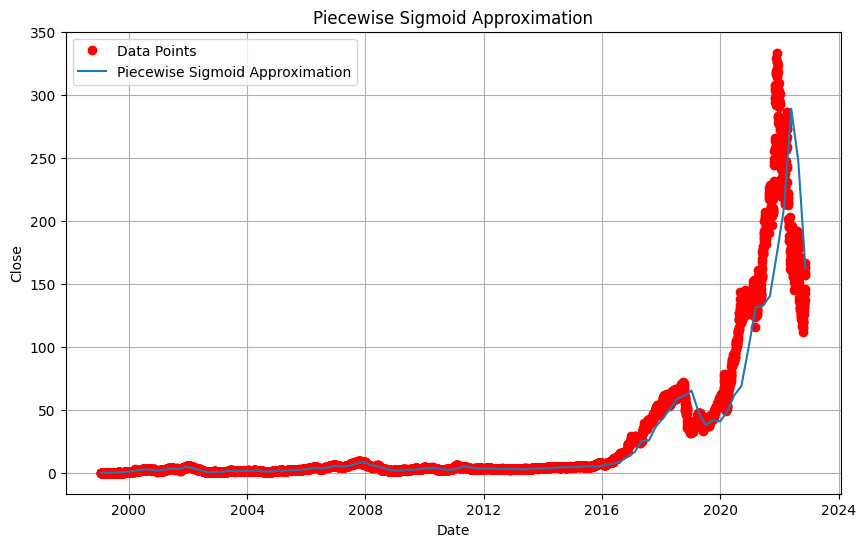

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
import pandas as pd

# Convert index to numerical values for fitting the polynomial
dates_numeric = df.index.astype(np.int64) // 10**9  # Convert to seconds since epoch
dates_numeric = np.array(dates_numeric)  # Convert to numpy array

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + expit(-x))

# Define the piecewise approximation function using a combination of sigmoid functions
def piecewise_approximation_function(x, params, n_pieces):
    piece_length = len(x) // n_pieces
    y = np.zeros_like(x, dtype=float)
    for i in range(n_pieces):
        start = i * piece_length
        end = (i + 1) * piece_length if i < n_pieces - 1 else len(x)
        a = params[i * 3]
        b = params[i * 3 + 1]
        c = params[i * 3 + 2]
        y[start:end] = c * sigmoid(a * x[start:end] + b)
    return y

# Define the loss function to minimize
def loss(params):
    n_pieces = len(params) // 3
    y_pred = piecewise_approximation_function(dates_numeric, params, n_pieces)
    return np.mean((df['Close'] - y_pred) ** 2)

# Initial parameters for optimization
n_pieces = 100  # Number of pieces to use
initial_params = np.random.randn(n_pieces * 3)

# Optimize the parameters to fit the data
result = minimize(loss, initial_params, method='L-BFGS-B')
optimized_params = result.x

# Define a range of dates for plotting the approximation
date_range = np.linspace(dates_numeric[0], dates_numeric[-1], 100)

# Calculate values for the optimized approximation function
closing_least_modules = piecewise_approximation_function(date_range, optimized_params, n_pieces)

# Convert date_range back to datetime for plotting
date_range = pd.to_datetime(date_range * 10**9)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_least_modules, label='Piecewise Sigmoid Approximation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Piecewise Sigmoid Approximation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Насколько хорошо сигмовидная функция соответствует данным по сравнению с полиномиальными методами?
- Попробуйте настроить параметры, чтобы увидеть, как они влияют на кривую.

### Ответ

- Сигмовидные функции часто устойчивее и «реалистичнее» моделируют процессы с насыщением, чем высокостепенные полиномы, которые склонны к сильным колебаниям на границах.
- При сложной динамике (несколько фаз роста) может потребоваться кусочная или многокомпонентная сигмоидная аппроксимация, а также тщательная настройка начальных параметров.

---

## **9. Корни полинома Чебышева для интерполяции**

### Обзор метода:
Полиномы Чебышева используются для минимизации погрешности аппроксимации. Используя их корни, вы можете выполнять более эффективную интерполяцию.

### Реализация:

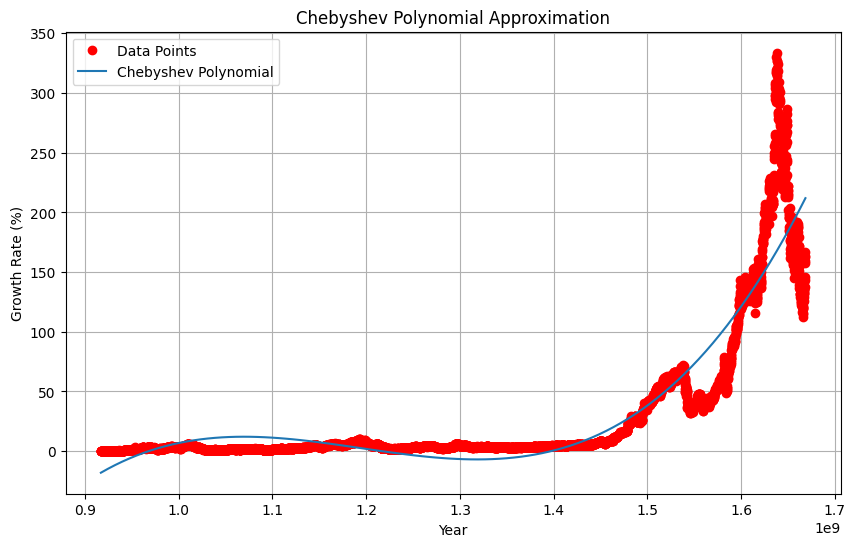

In [27]:
from numpy.polynomial.chebyshev import Chebyshev

dates_numeric = df.index.astype(np.int64) // 10**9  # Convert to seconds since epoch
# Chebyshev interpolation method
chebyshev_poly = Chebyshev.fit(dates_numeric, df['Close'], deg=3)

date_range = np.linspace(dates_numeric[0], dates_numeric[-1], 100)

# Calculate values
closing_chebyshev = chebyshev_poly(date_range)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(dates_numeric, df['Close'], 'ro', label='Data Points')
plt.plot(date_range, closing_chebyshev, label='Chebyshev Polynomial')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.title('Chebyshev Polynomial Approximation')
plt.legend()
plt.grid(True)
plt.show()

### Задача:
- Чем интерполяция по Чебышеву отличается от полиномиальной интерполяции? Какими преимуществами она обладает?

### Ответ

**Ключевое отличие**:  
- При «обычной» полиномиальной интерполяции мы можем использовать равномерно распределённые точки или любые другие узлы, и тогда возникает риск сильных колебаний на краях (эффект Рунге).  
- **Интерполяция по Чебышеву** использует специальные узлы (корни или экстремумы полиномов Чебышёва), что помогает минимизировать максимум отклонения (минимаксная аппроксимация) и снижает амплитуду колебаний полинома.

**Преимущества**:  
1. **Снижение эффекта Рунге**: полином не «гуляет» на краях так сильно, как при равномерном распределении узлов.  
2. **Более стабильные вычисления**: меньше вероятность больших численных ошибок при высоких степенях.  
3. **Лучшая аппроксимация при той же степени**: за счёт оптимального расположения точек полином Чебышёва часто даёт более точный результат, чем «обычный» полином такой же степени.

---

## **10. Заключение и анализ**

В этом разделе предлагается сравнить различные методы:
- Какой метод лучше всего подходит для данного набора данных?
- Какой метод является наиболее эффективным с точки зрения вычислений?
- Какая модель дает наиболее точные прогнозы при обобщении на невидимые данные?

### Ответ

**1. Какой метод лучше всего подходит для данного набора данных?**  
Для финансовых временных рядов (с быстрым ростом и потенциалом насыщения) обычно **кусочные сплайны** или **логарифмическая регрессия** (иногда с дополнительными нелинейными компонентами) дают более «гладкие» и реалистичные результаты. Классические полиномы высокой степени часто переобучаются и демонстрируют эффект Рунге. Кусочная сигмоидная аппроксимация также может хорошо работать, если данные имеют несколько фаз роста.

**2. Какой метод является наиболее эффективным с точки зрения вычислений?**  
- **Простая полиномиальная регрессия** (малой степени) обычно решается очень быстро через линейную алгебру (закрытая формула).  
- **Кубические сплайны** требуют предварительного решения системы линейных уравнений, но для больших наборов данных это тоже достаточно эффективно (алгоритмы масштабируются примерно за O(n)).  
- Методы с итеративной оптимизацией (наименьших модулей, кусочные сигмоиды) могут быть дороже по вычислительным ресурсам, так как требуют численных методов оптимизации.

**3. Какая модель даёт наиболее точные прогнозы при обобщении на невидимые данные?**  
- Зависит от природы данных и наличия шума. В целом, **модели, избегающие переобучения** (сплайны, логарифмические или экспоненциальные регрессии с разумным числом параметров) обычно лучше экстраполируют.  
- **Проверить точность** можно только эмпирически, разделив выборку на обучающую и тестовую (или используя кросс-валидацию). На практике нередко лучшим вариантом оказывается **сглаженная (регуляризованная) модель**, которая не пытается идеально подогнать каждую точку, а ищет баланс между точностью и устойчивостью.

---

## Экстра практика на тех же данных. Давайте попробуем провести экстра-поляцию!🧙

### Сначала давайте попробуем провести экстраполяцию теми же методами, что и раньше, и построить график результата

In [40]:
# All polynomials built before:
polonomials = [poly_lagrange, newton_interpolator, cubic_spline, p, p_log, lambda x: a*x + b, lambda x: piecewise_approximation_function(x, optimized_params, n_pieces), chebyshev_poly]
polonomial_labels = ['Lagrange', 'Newton', 'Spline', 'Least Squares', 'Logarithmic Least Squares', 'Least Modules', 'Sigmoid', 'Chebyshev']

<ipython-input-19-e7d7293cbf34>:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


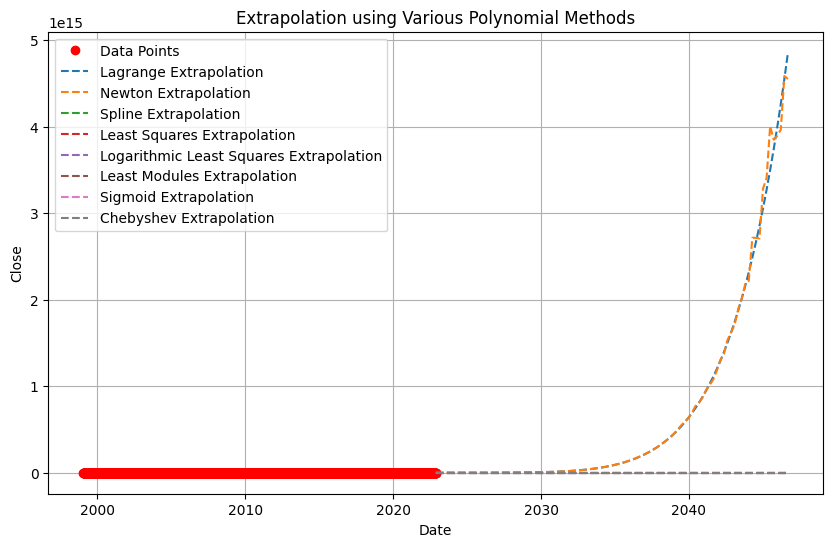

In [41]:
# Define a new range of dates for extrapolation
extrapolation_range = np.linspace(dates_numeric[-1], dates_numeric[-1] + (dates_numeric[-1] - dates_numeric[0]), 100)

# Calculate extrapolated values using the least squares polynomial
extrapolated_values = p(extrapolation_range)

# Convert extrapolation_range back to datetime for plotting
extrapolation_dates = pd.to_datetime(extrapolation_range * 10**9)

# Apply each polinomial to the extrapolation range
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], 'ro', label='Data Points')  # Исходные данные

# Цикл по всем полиномам
for poly, label in zip(polonomials, polonomial_labels):
    # Вычисляем значения на новом диапазоне
    y_extrap = poly(extrapolation_range)
    # Строим экстраполированную кривую
    plt.plot(extrapolation_dates, y_extrap, '--', label=f'{label} Extrapolation')

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Extrapolation using Various Polynomial Methods')
plt.legend()
plt.grid(True)
plt.show()

### А теперь попробуем добавить немного машинного обучения, чтобы предсказывать значения

Не надо бояться машинного обучения как чёрной магии, под капотом у неё всё те же численные методы (ака. вычислительная математика).

In [45]:
%pip install scikit-learn
%pip install tensorflow

In [46]:
output_var = pd.DataFrame(df['Close'])

In [47]:
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

In [ ]:
feature_transform.shape

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
import tensorflow as tf
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(tf.keras.layers.Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
tf.keras.utils.plot_model(lstm, show_shapes=True, show_layer_names=True)

In [ ]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

In [ ]:
y_pred= lstm.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

Какие выводы Вы можете сделать по этим примерам и по всей практической работе в целом? Что нового Вы лично для себя узнали?

ВАШ КОММЕНТАРИЙ ЗДЕСЬ